In [17]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
from sksurv.util import Surv
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import mysql.connector
import warnings
from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest


warnings.filterwarnings("ignore")

In [2]:
conn = mysql.connector.connect(
    host="localhost",
    user="daniil",
    password="000",
    database="dims"
)

query = "SELECT * FROM users"
df = pd.read_sql(query, conn)


/tmp/ipykernel_6007/2696168602.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [16]:
#conn.close()

In [237]:
def make_data(conn):
    incidents = pd.read_sql("SELECT * FROM incidents", conn)
    
    task_stage = pd.read_sql("SELECT * FROM task_stages", conn)
    task_stage['task_stage_id']=task_stage['id']
    
    tasks = pd.read_sql("SELECT * FROM tasks", conn)
    tasks['task_id'] = tasks.id
    tasks = tasks[tasks.taskable_type != 'App\\Models\\ServiceDesk\\Reclamation']

    service_objects = pd.read_sql("SELECT * FROM service_objects", conn)
    service_objects['service_object_id'] = service_objects.id
    service_objects['service_title'] = service_objects.title
    service_object_task = pd.read_sql("SELECT * FROM service_object_task", conn)
    service_objects = service_objects.merge(service_object_task, how='left', on='service_object_id')

    incidents = pd.read_sql("SELECT * FROM incidents", conn)
    incident_types = pd.read_sql("SELECT * FROM incident_types", conn)
    incident_service_object = pd.read_sql("SELECT * FROM incident_service_object", conn)
    incidents['incident_id'] = incidents.id
    
    incident_types['incident_type_id'] = incident_types.id
    incident_types['title_incident_type'] = incident_types.title
    incident_types['description_incident_type'] = incident_types.description
    incidents = incidents.merge(incident_types[['incident_type_id', 'title_incident_type', 'description_incident_type']], 
                               how = 'left', on='incident_type_id')
    incidents = incidents.merge(incident_service_object, how='left', on='incident_id')
    withoutdub = -incidents.drop(['id', 'incident_id'], axis=1).duplicated()
    incidents = incidents[withoutdub]
    incidents = incidents[pd.isna(incidents.deleted_at)]
    
    incidents['description_incident'] = incidents.description
    incidents['closed_at_incident'] = incidents.closed_at
    incidents['created_at_incident'] = incidents.created_at
    incidents['task_id'] = incidents.assigner_id

    trans = pd.read_sql("SELECT * FROM task_transitions", conn)
    columns = ['task_stage_id', 'title', 'action_title']
    trans = trans.merge(task_stage[columns], how = 'left', on='task_stage_id' )
    trans = trans.merge(tasks[['task_id', 'description', 'account_id', 'taskable_type', 'deadline_at']], how='left', on='task_id')
    trans = trans.merge(service_objects[['service_title', 'task_id', 'service_object_id','customer_id', 'object_type_id']], how='left', on='task_id')
    trans = trans.merge(incidents[['incident_id', 'task_id', 'created_at_incident', 'incident_type_id', 'description_incident_type']], how='left', on='task_id')

    return trans

trans = make_data(conn)
trans

,id,task_id,task_stage_id,transitioned_by,transitioned_at,created_at,updated_at,title,action_title,description,...,taskable_type,deadline_at,service_title,service_object_id,customer_id,object_type_id,incident_id,created_at_incident,incident_type_id,description_incident_type
0,1,1,1,3,2021-07-19 07:52:49,2022-01-23 21:04:19,2022-01-23 21:04:19,Поставлена,Вернуть на доработку,Восстановить работу метео.,...,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN
1,2,1,2,13,2021-07-20 23:20:37,2022-01-23 21:04:19,2022-01-23 21:04:19,Принята,Принять в работу,Восстановить работу метео.,...,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN
2,3,1,3,13,2021-07-20 23:22:07,2022-01-23 21:04:19,2022-01-23 21:04:19,Выполнена,Отметить выполненной,Восстановить работу метео.,...,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN
3,4,1,1,13,2021-07-21 10:49:53,2022-01-23 21:04:19,2022-01-23 21:04:19,Поставлена,Вернуть на доработку,Восстановить работу метео.,...,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN
4,5,1,2,13,2021-07-23 16:15:59,2022-01-23 21:04:19,2022-01-23 21:04:19,Принята,Принять в работу,Восстановить работу метео.,...,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414686,288433,72645,3,209,2024-03-25 23:15:22,2024-03-25 20:15:22,2024-03-25 20:15:22,Выполнена,Отметить выполненной,восстановить работу,...,App\Models\ServiceDesk\Incident,2024-03-27 02:00:00,км 69+900 а/д ст-ца Журавская - г.Тихорецк,537.0,2.0,2.0,NaN,NaT,NaN,NaN
414687,288434,72604,2,139,2024-03-25 23:30:18,2024-03-25 20:30:18,2024-03-25 20:30:18,Принята,Принять в работу,восстановить работу.,...,App\Models\ServiceDesk\Incident,2024-03-30 02:00:00,км 6+700 а/д Подъезд к х.Морозовский,955.0,2.0,2.0,NaN,NaT,NaN,NaN
414688,288435,72604,3,139,2024-03-25 23:32:29,2024-03-25 20:32:29,2024-03-25 20:32:29,Выполнена,Отметить выполненной,восстановить работу.,...,App\Models\ServiceDesk\Incident,2024-03-30 02:00:00,км 6+700 а/д Подъезд к х.Морозовский,955.0,2.0,2.0,NaN,NaT,NaN,NaN
414689,288436,72600,2,139,2024-03-25 23:41:07,2024-03-25 20:41:07,2024-03-25 20:41:07,Принята,Принять в работу,разобраться с нулевыми данными,...,App\Models\ServiceDesk\Incident,2024-03-30 02:00:00,None,7861.0,2.0,5.0,NaN,NaT,NaN,NaN


In [14]:
cols = ['id', 'task_id', 'task_stage_id', 'transitioned_by', 'transitioned_at', 'created_at', 'account_id', 
        'taskable_type', 'customer_id', 'object_type_id', 'deadline_at', 'created_at_incident', 'incident_type_id']
categorical = ['taskable_type']

In [13]:
def collect_data(df, categorical, num_days = 250):
    services = trans.service_object_id.unique()
    encoder = OrdinalEncoder()
    for col in categorical:
        encoded = encoder.fit_transform(df[[col]])

# Добавляем закодированные значения в DataFrame
        df[f'{col}_encoded'] = encoded
        
        # Удаление исходного категориального столбца (если требуется)
        # df.drop(col, axis=1, inplace=True)
    n_cols = len(df.columns) - 4
    mode = df.incident_type_id.mode()
    X = np.zeros((1, n_cols))
    y = Surv.from_arrays([True], [0], name_event='target').reshape(1, 1)
    end_point = df.created_at.max()
    for object in services:
        tasks = df[trans.service_object_id == object]
        tasks = tasks.sort_values(by='transitioned_at')
        task_ids = tasks.task_id.unique()
        num_collects = len(tasks[tasks.task_stage_id == 3])
        tasks['days2deadline'] = (tasks['deadline_at'] - tasks['transitioned_at']).dt.days
        tasks['daysSinceCreatetime'] = (tasks['transitioned_at'] - tasks['created_at']).dt.days
        if num_collects > 1:
            tasks_collects = tasks[tasks.task_stage_id == 3]
            tasks_collects['incident_type_id'] = tasks_collects['incident_type_id'].fillna(mode[0])
            tasks_collects['time'] = [min((tasks_collects['transitioned_at'].iloc[i] - tasks_collects['transitioned_at'].iloc[i-1]).days + 1, num_days)
                                     for i in range(1, num_collects)] + [min((end_point - tasks_collects['transitioned_at'].iloc[num_collects-1]).days + 1, num_days)]
            
            tasks_collects['target'] = [tasks_collects['time'].iloc[i] < num_days for i in range(num_collects)]
            tasks_collects = tasks_collects.drop(['transitioned_at', 'created_at', 'deadline_at', 'created_at_incident'] + categorical, axis = 1)
            
            X_batch = np.array(tasks_collects.drop(['time', 'target', 'id'], axis = 1))
            y_batch = Surv.from_dataframe('target', 'time', tasks_collects).reshape(num_collects, 1)

            X = np.vstack((X, X_batch))
            y = np.vstack((y, y_batch))
    return X[1:, :], y[1:, :], tasks
            
            

X, y, t = collect_data(trans[cols], categorical)
X

array([[ 1.0000e+00,  3.0000e+00,  1.3000e+01, ...,  1.0000e+00,
        -1.0000e+00, -1.8700e+02],
       [ 1.0000e+00,  3.0000e+00,  1.3000e+01, ...,  1.0000e+00,
        -4.0000e+00, -1.8500e+02],
       [ 2.0000e+00,  3.0000e+00,  1.3000e+01, ...,  1.0000e+00,
         0.0000e+00, -1.7800e+02],
       ...,
       [ 6.5863e+04,  3.0000e+00,  1.3900e+02, ...,  1.0000e+00,
        -4.0000e+00,  0.0000e+00],
       [ 6.5879e+04,  3.0000e+00,  1.7000e+02, ...,  1.0000e+00,
        -5.0000e+00,  0.0000e+00],
       [ 6.7225e+04,  3.0000e+00,  1.7000e+02, ...,  1.0000e+00,
        -2.0000e+00,  0.0000e+00]])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [18]:
estimator = GradientBoostingSurvivalAnalysis(
    n_estimators = 500,
    max_depth=7,
    max_features='sqrt',
    learning_rate = 0.01,
    # verbose=50, 
    # loss = 'squared'
).fit(X_train, y_train.squeeze(-1))

estimator.score(X_test, y_test.squeeze(-1))

0.882545177897207

In [107]:
threshold = 0.5
y_surv = estimator.predict_survival_function(X_test, return_array=True)
predicted_death_day = np.argmax(y_surv <= threshold, axis=1)
predicted_death_day.shape

(1057,)

In [98]:
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error

In [106]:
y_test_days = [y_test[i][0][1] for i in range(predicted_death_day.shape[0])]
mse = mean_squared_error(y_test_days, predicted_death_day)
mse

4787.013245033113

In [108]:
mae = mean_absolute_error(y_test_days, predicted_death_day)
mae

38.57048249763481

In [67]:
y_test[0][

array([( True, 1.)], dtype=[('target', '?'), ('time', '<f8')])

In [19]:
def predict_customer(df, X, y, estimator, customer_id, max_num = 50):
    idx = df[df.customer_id == customer_id].task_id.unique()
    task_ids = np.isin(X[:, 0], idx)
    if len(task_ids) > max_num:
        task_ids = np.where(task_ids)[0][-max_num:]
    data = X[task_ids]
    survival_function = estimator.predict_survival_function(data, return_array=True)
    cumulative_hazard_function = estimator.predict_cumulative_hazard_function(data, return_array=True)
    return survival_function, cumulative_hazard_function
    

survival_function, cumulative_hazard_function = predict_customer(trans, X, y, estimator, 1)

In [112]:
def binnirize_arr(y, num_bins = 10):
    dev = int(len(y) / n_bins)
    y_binned = np.mean(y[:(len(y)//dev)*dev].reshape(-1, dev), axis=1)
    x_binned = np.arange(0, y[:(len(y)//dev)*dev].shape[0], dev)
    return x_binned, y_binned

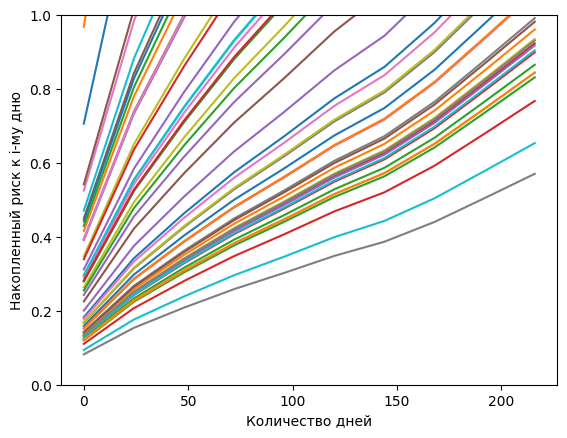

In [117]:
for obj in cumulative_hazard_function:
    x_bin, y_bin = binnirize_arr(obj)
    plt.plot(x_bin, y_bin)

plt.ylim(0, 1)
plt.xlabel("Количество дней")
plt.ylabel("Накопленный риск к i-му дню")
plt.show()

In [114]:
def predict_task_id_any_customer(df, X, y, estimator, task_id, max_num = 10):
    x = X[X[:, 0] == task_id][0]
    lst = []
    survival_function = estimator.predict_survival_function([x], return_array=True)[0]

    x_arr, obj_binned = binnirize_arr(survival_function)
    
    lst.append((x[4], obj_binned.tolist()))
    for i in range(max_num):
        x[4] = np.random.randint(1, 395)
        survival_function = estimator.predict_survival_function([x], return_array=True)[0]
        x_arr, obj_binned = binnirize_arr(survival_function)
        lst.append((x[4], obj_binned.tolist()))
    return lst, x_arr.tolist()

lst = predict_task_id_any_customer(trans, X, y, estimator, 500, max_num = 10)

In [187]:
def predict_task_id_any_incident(df, X, y, estimator, task_id, max_num = 10):
    x = X[X[:, 0] == task_id][0]
    lst = []
    survival_function = estimator.predict_survival_function([x], return_array=True)[0]

    x_arr, obj_binned = binnirize_arr(survival_function)
    
    lst.append((x[6], obj_binned.tolist()))
    for i in range(max_num):
        x[6] = np.random.randint(1, 30)
        survival_function = estimator.predict_survival_function([x], return_array=True)[0]
        x_arr, obj_binned = binnirize_arr(survival_function)
        lst.append((x[6], obj_binned.tolist()))
    return lst, x_arr.tolist()

lst = predict_task_id_any_incident(trans, X, y, estimator, 500, max_num = 10)

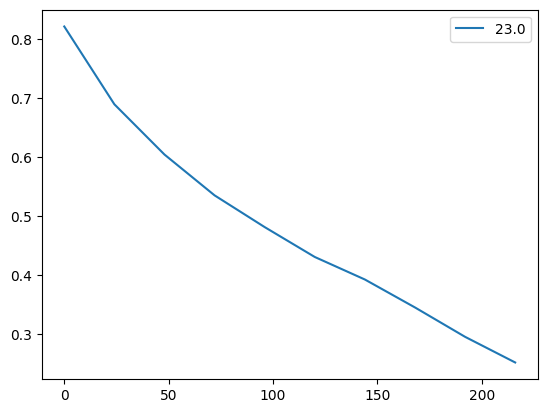

In [304]:
lst, x_arr = predict_task_id_any_incident(trans, X, y, estimator, 500, max_num = 0)
for name, obj in lst:
    plt.plot(x_arr, obj, label=name)
plt.legend()
plt.show()

In [218]:
trans.created_at_incident

0        NaT
1        NaT
2        NaT
3        NaT
4        NaT
          ..
414686   NaT
414687   NaT
414688   NaT
414689   NaT
414690   NaT
Name: created_at_incident, Length: 414691, dtype: datetime64[ns]

In [268]:
trans['days2deadline'] = (trans['deadline_at'] - trans['transitioned_at']).dt.days
trans['daysSinceCreatetime'] = (trans['transitioned_at'] - trans['created_at_incident']).dt.days
trans.loc[trans['daysSinceCreatetime'] < 0, 'daysSinceCreatetime'] = np.nan
aggregated_data = trans[trans.task_stage_id == 3].groupby('description_incident_type')['daysSinceCreatetime'].mean().reset_index()
aggregated_data = aggregated_data.dropna().sort_values(by='daysSinceCreatetime')
print(aggregated_data)

                            description_incident_type  daysSinceCreatetime
13    Отсутствие напряжения на батарее в ночное время            18.000000
10    Отсутствие данных с отдельного датчика/датчиков            22.500000
15             С объекта приходят некорректные данные            23.000000
4            Напряжение на нагрузке ниже номинального            32.000000
2   Информация на ТПИ/ЗПИ либо не выводится, либо ...            34.000000
16         Самопроизвольные переход в жёлтый мигающий            40.000000
11  Отсутствие данных, превышающее регламентные сроки            48.458333
7                                 Нестабильная работа            49.500000
18  Ухудшение качества изображения камеры, связанн...            64.000000
9                                Отключение светофора            65.500000


In [244]:
aggregated_data.to_csv('gist_incident_type_days')

In [238]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414691 entries, 0 to 414690
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         414691 non-null  int64         
 1   task_id                    414691 non-null  int64         
 2   task_stage_id              414691 non-null  int64         
 3   transitioned_by            414691 non-null  int64         
 4   transitioned_at            414691 non-null  datetime64[ns]
 5   created_at                 414691 non-null  datetime64[ns]
 6   updated_at                 414691 non-null  datetime64[ns]
 7   title                      414691 non-null  object        
 8   action_title               414691 non-null  object        
 9   description                311154 non-null  object        
 10  account_id                 414350 non-null  float64       
 11  taskable_type              414350 non-null  object  

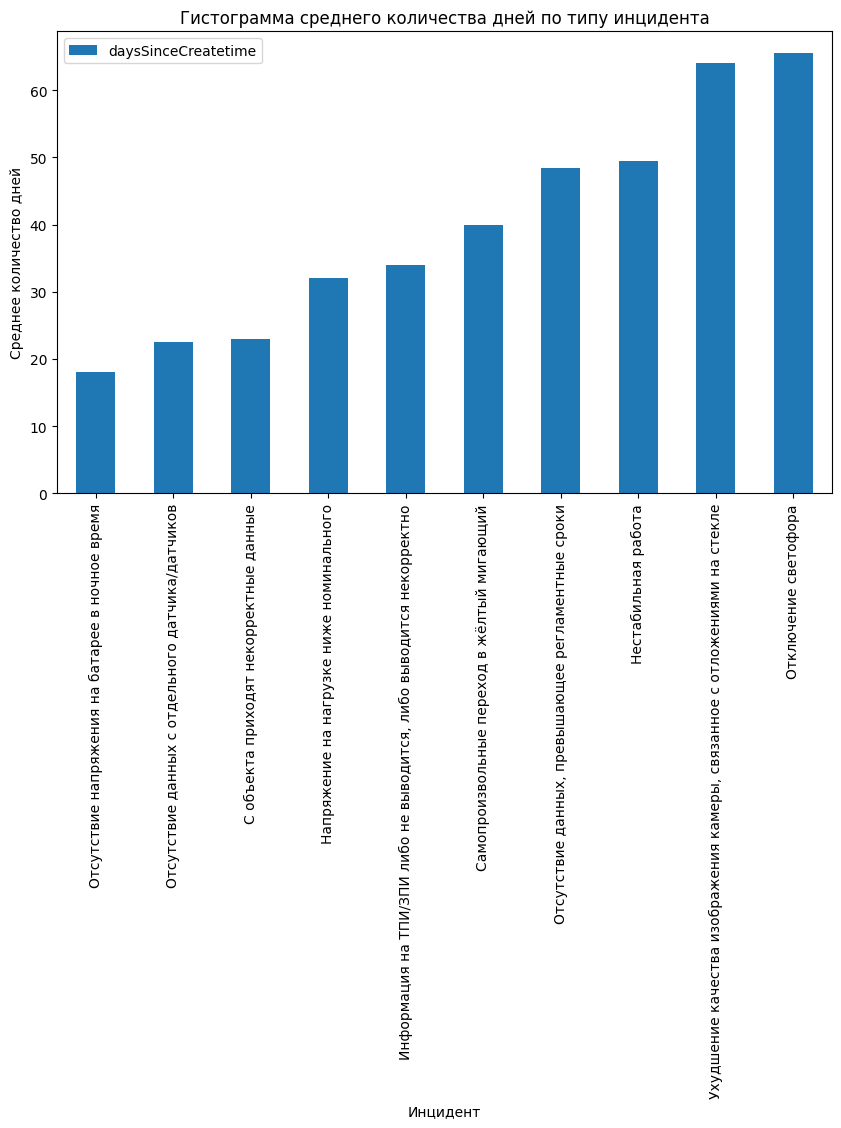

In [269]:
aggregated_data.plot.bar(x='description_incident_type', y='daysSinceCreatetime', figsize=(10, 6))
plt.xlabel('Инцидент')
plt.ylabel('Среднее количество дней')
plt.title('Гистограмма среднего количества дней по типу инцидента')
plt.show()

In [261]:
aggregated_data.description_incident_type.values

array(['Информация на ТПИ/ЗПИ либо не выводится, либо выводится некорректно',
       'Напряжение на нагрузке ниже номинального', 'Нестабильная работа',
       'Отключение светофора',
       'Отсутствие данных с отдельного датчика/датчиков',
       'Отсутствие данных, превышающее регламентные сроки',
       'Отсутствие напряжения на батарее в ночное время',
       'С объекта приходят некорректные данные',
       'Самопроизвольные переход в жёлтый мигающий',
       'Ухудшение качества изображения камеры, связанное с отложениями на стекле'],
      dtype=object)

Дальше черновик, мусор, калл

In [294]:
trans.head()

,id,task_id,task_stage_id,transitioned_by,transitioned_at,created_at,updated_at,title,action_title,description,...,service_title,service_object_id,customer_id,object_type_id,incident_id,created_at_incident,incident_type_id,description_incident_type,days2deadline,daysSinceCreatetime
0,1,1,1,3,2021-07-19 07:52:49,2022-01-23 21:04:19,2022-01-23 21:04:19,Поставлена,Вернуть на доработку,Восстановить работу метео.,...,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN,0.0,NaN
1,2,1,2,13,2021-07-20 23:20:37,2022-01-23 21:04:19,2022-01-23 21:04:19,Принята,Принять в работу,Восстановить работу метео.,...,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN,-1.0,NaN
2,3,1,3,13,2021-07-20 23:22:07,2022-01-23 21:04:19,2022-01-23 21:04:19,Выполнена,Отметить выполненной,Восстановить работу метео.,...,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN,-1.0,NaN
3,4,1,1,13,2021-07-21 10:49:53,2022-01-23 21:04:19,2022-01-23 21:04:19,Поставлена,Вернуть на доработку,Восстановить работу метео.,...,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN,-2.0,NaN
4,5,1,2,13,2021-07-23 16:15:59,2022-01-23 21:04:19,2022-01-23 21:04:19,Принята,Принять в работу,Восстановить работу метео.,...,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN,NaN,-4.0,NaN


In [302]:
q = trans[trans.task_stage_id == 3][['customer_id', 'service_object_id', 'incident_type_id']].dropna()
q[q.customer_id == 1].duplicated().sum()

2456

In [4]:
incidents = pd.read_sql("SELECT * FROM incidents", conn)
incidents

/tmp/ipykernel_1953433/2066848219.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  incidents = pd.read_sql("SELECT * FROM incidents", conn)


,id,account_id,assigner_id,incident_type_id,description,closed_at,is_verified,exclude_from_stat,deleted_at,created_at,updated_at
0,1,1,NaN,1,None,2021-12-27 02:45:09,0,0,2022-02-16 16:28:55,2021-01-24 13:09:21,2022-02-16 16:28:55
1,2,1,NaN,1,None,2021-12-27 02:45:09,0,0,2022-02-16 16:28:55,2021-04-23 15:07:29,2022-02-16 16:28:55
2,3,1,NaN,1,None,2021-12-27 02:45:09,0,0,2022-02-16 16:28:55,2021-05-05 17:07:58,2022-02-16 16:28:55
3,4,1,NaN,1,None,2021-12-27 02:45:09,0,0,2022-02-16 16:28:55,2021-08-26 08:53:40,2022-02-16 16:28:55
4,5,1,NaN,1,None,2021-12-27 02:45:09,0,0,2022-02-16 16:28:55,2021-12-26 01:12:13,2022-02-16 16:28:55
...,...,...,...,...,...,...,...,...,...,...,...
584785,589487,1,NaN,44,None,NaT,0,0,NaT,2024-03-25 23:07:32,2024-03-25 23:07:32
584786,589488,2,NaN,22,None,NaT,0,0,NaT,2024-03-25 23:07:48,2024-03-25 23:07:48
584787,589489,1,NaN,13,None,NaT,0,0,NaT,2024-03-25 23:21:11,2024-03-25 23:21:11
584788,589490,1,NaN,1,None,NaT,0,0,NaT,2024-03-25 23:25:20,2024-03-25 23:25:20


In [5]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584790 entries, 0 to 584789
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 584790 non-null  int64         
 1   account_id         584790 non-null  int64         
 2   assigner_id        5894 non-null    float64       
 3   incident_type_id   584790 non-null  int64         
 4   description        6603 non-null    object        
 5   closed_at          577129 non-null  datetime64[ns]
 6   is_verified        584790 non-null  int64         
 7   exclude_from_stat  584790 non-null  int64         
 8   deleted_at         449184 non-null  datetime64[ns]
 9   created_at         584790 non-null  datetime64[ns]
 10  updated_at         584790 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(5), object(1)
memory usage: 49.1+ MB


(array([4.85470e+04, 4.80000e+01, 8.78000e+03, 8.20000e+01, 5.20183e+05,
        4.82100e+03, 2.06000e+02, 1.00000e+00, 3.48000e+02, 1.77400e+03]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <BarContainer object of 10 artists>)

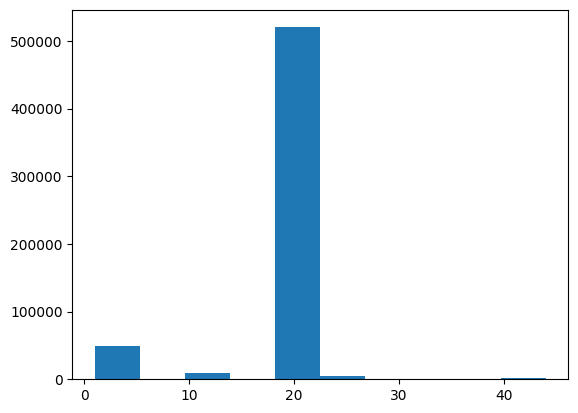

In [6]:
plt.hist(incidents.incident_type_id)

(array([577736.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   7054.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

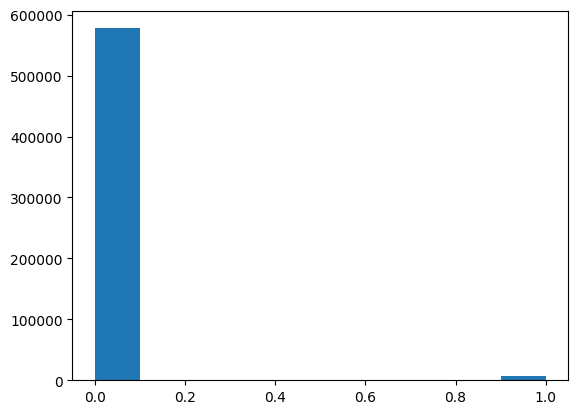

In [7]:
plt.hist(incidents.is_verified)

(array([19024., 19028., 19032., 19036., 19040., 19044., 19048., 19052.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19028.0, 0, '2022-02-05'),
  Text(19032.0, 0, '2022-02-09'),
  Text(19036.0, 0, '2022-02-13'),
  Text(19040.0, 0, '2022-02-17'),
  Text(19044.0, 0, '2022-02-21'),
  Text(19048.0, 0, '2022-02-25'),
  Text(19052.0, 0, '2022-03-01')])

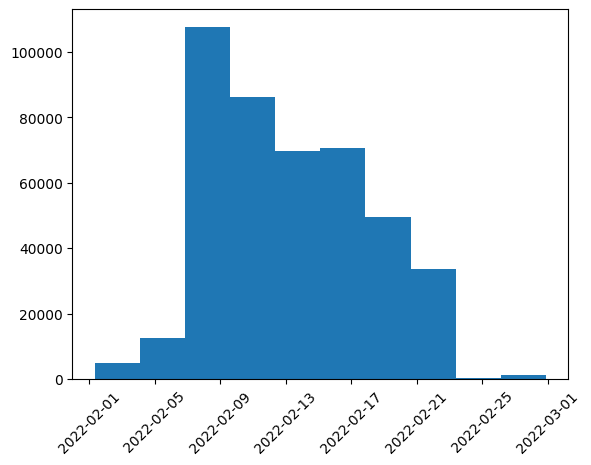

In [8]:
plt.hist(incidents.created_at.iloc[9000:-140000])
plt.xticks(rotation=45)  # Угол поворота в градусах


In [9]:
x

NameError: name 'x' is not defined

In [ ]:
plt.hist(incidents.created_at)
plt.xticks(rotation=45)  # Угол поворота в градусах


In [21]:
task_stage = pd.read_sql("SELECT * FROM task_stages", conn)
task_stage['task_stage_id']=task_stage['id']
task_stage

/tmp/ipykernel_1953433/145574137.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  task_stage = pd.read_sql("SELECT * FROM task_stages", conn)


,id,process_id,title,action_title,action_icon,color,is_start,is_fulfilled,shifts_deadline,is_closed,is_canceled,infl_fulfillment,reassignable,requires,deleted_at,created_at,updated_at,task_stage_id
0,1,1,Поставлена,Вернуть на доработку,mdi-backup-restore,#D32F2F,1,0,0,0,0,1,1,"{""image"": 0, ""report"": 1, ""approvement"": 0, ""f...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,1
1,2,1,Принята,Принять в работу,mdi-play-circle-outline,#FFA000,0,0,0,0,0,1,0,"{""image"": 0, ""timer"": 1, ""report"": 0, ""approve...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,2
2,3,1,Выполнена,Отметить выполненной,mdi-stop-circle-outline,#AFB42B,0,1,0,0,0,1,0,"{""image"": 1, ""report"": 1, ""operations"": 1, ""ap...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,3
3,4,1,Отложена,Отложить,mdi-pause-circle-outline,#AFB42B,0,0,1,0,0,1,0,"{""image"": 0, ""report"": 1, ""approvement"": 1, ""f...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,4
4,5,1,Закрыта,Закрыть,mdi-check-circle-outline,#558B2F,0,1,0,1,0,0,0,"{""image"": 0, ""report"": 0, ""approvement"": 0, ""f...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,5
5,6,1,Произошло самовосстановление,Отметить самовосстановившимся,mdi-recycle,#0097A7,0,1,0,0,0,1,0,"{""image"": 0, ""report"": 0, ""approvement"": 0, ""f...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,6
6,7,1,Отменена,Отменить,mdi-close-circle-outline,#0277BD,0,1,0,1,1,1,0,"{""image"": 0, ""report"": 1, ""approvement"": 0, ""f...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,7
7,8,2,Поставлена,Вернуть на доработку,mdi-backup-restore,#D32F2F,1,0,0,0,0,1,1,"{""image"": 0, ""report"": 1, ""approvement"": 0, ""f...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,8
8,9,2,Принята,Принять в работу,mdi-play-circle-outline,#FFA000,0,0,0,0,0,1,0,"{""image"": 0, ""timer"": 1, ""report"": 0, ""approve...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,9
9,10,2,Выполнена,Отметить выполненной,mdi-stop-circle-outline,#AFB42B,0,1,0,0,0,1,0,"{""image"": 1, ""report"": 1, ""operations"": 1, ""ap...",None,2022-01-23 21:01:04,2022-01-23 21:01:04,10


In [10]:
tasks = pd.read_sql("SELECT * FROM tasks", conn)
tasks['task_id'] = tasks.id
tasks = tasks[tasks.taskable_type != 'App\\Models\\ServiceDesk\\Reclamation']

tasks

/tmp/ipykernel_1953433/1062921213.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tasks = pd.read_sql("SELECT * FROM tasks", conn)


,id,account_id,assigner_id,assignable_type,assignable_id,taskable_type,taskable_id,description,deadline_at,deleted_at,created_at,updated_at,task_id
0,1,1,3,App\Models\User,13,App\Models\ServiceDesk\Incident,18,Восстановить работу метео.,2021-07-20 02:00:00,None,2021-07-19 07:52:49,2022-01-23 21:04:19,1
1,2,1,13,App\Models\User,13,App\Models\ServiceDesk\Incident,22,Проверить АКБ и ЗУ,2021-07-31 02:00:00,None,2021-07-30 18:27:51,2022-01-23 21:04:19,2
2,3,1,13,App\Models\User,13,App\Models\ServiceDesk\Incident,31,Заменить АКБ,2021-07-31 02:00:00,None,2021-07-30 18:10:50,2022-01-23 21:04:19,3
3,4,1,4,App\Models\User,11,App\Models\ServiceDesk\Incident,57,"Выяснить причину, по возможности восстановить ...",2021-12-04 02:00:00,None,2021-11-29 09:48:13,2022-01-23 21:04:19,4
4,5,1,4,App\Models\User,11,App\Models\ServiceDesk\Incident,58,Восстановить работу ПУИД,2021-12-05 02:00:00,None,2021-12-02 07:40:14,2022-01-23 21:04:20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72654,72667,2,210,App\Models\User,210,App\Models\ServiceDesk\Incident,589360,проверка ДВС,2024-03-31 02:00:00,None,2024-03-25 19:26:42,2024-03-25 19:26:42,72667
72655,72668,2,210,App\Models\User,210,App\Models\ServiceDesk\Incident,589359,проверка ДТВ,2024-03-31 02:00:00,None,2024-03-25 19:27:04,2024-03-25 19:27:04,72668
72656,72669,2,210,App\Models\User,210,App\Models\ServiceDesk\Incident,589337,проверка метео,2024-04-10 02:00:00,None,2024-03-25 19:27:38,2024-03-25 19:27:38,72669
72657,72670,2,210,App\Models\User,210,App\Models\ServiceDesk\Incident,589294,проверка видео,2024-04-10 02:00:00,None,2024-03-25 19:27:54,2024-03-25 19:27:54,72670


In [11]:
end_point = tasks.created_at.max()
end_point

Timestamp('2024-03-25 19:28:44')

([0, 1, 2],
 [Text(0, 0, 'App\\Models\\ServiceDesk\\Incident'),
  Text(1, 0, 'App\\Models\\ServiceDesk\\Regular'),
  Text(2, 0, 'App\\Models\\ServiceDesk\\Assignment')])

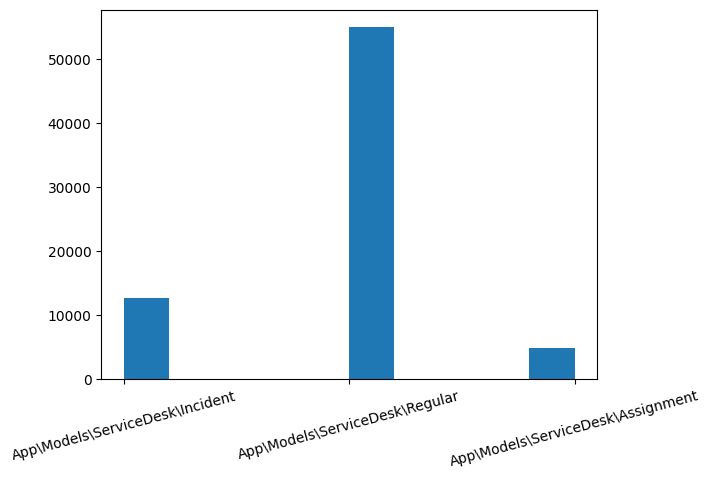

In [12]:
plt.hist(tasks.taskable_type)
plt.xticks(rotation=15)

In [13]:
service_objects = pd.read_sql("SELECT * FROM service_objects", conn)
service_objects['service_object_id'] = service_objects.id
service_objects['service_title'] = service_objects.title
service_object_task = pd.read_sql("SELECT * FROM service_object_task", conn)
service_objects = service_objects.merge(service_object_task, how='left', on='service_object_id')
service_objects

/tmp/ipykernel_1953433/1924591630.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  service_objects = pd.read_sql("SELECT * FROM service_objects", conn)
/tmp/ipykernel_1953433/1924591630.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  service_object_task = pd.read_sql("SELECT * FROM service_object_task", conn)


,id,account_id,object_type_id,customer_id,place_id,title,sub_title,is_demounted,is_out_of_service,is_commissioned,is_operating,deleted_at,created_at,updated_at,service_object_id,service_title,task_id
0,1,1,3,1,1,км 4+700 а/д А-149 Адлер-Красная поляна,None,0,0,1,1,NaT,2022-01-23 21:01:13,2022-01-23 21:01:13,1,км 4+700 а/д А-149 Адлер-Красная поляна,3725.0
1,1,1,3,1,1,км 4+700 а/д А-149 Адлер-Красная поляна,None,0,0,1,1,NaT,2022-01-23 21:01:13,2022-01-23 21:01:13,1,км 4+700 а/д А-149 Адлер-Красная поляна,3809.0
2,1,1,3,1,1,км 4+700 а/д А-149 Адлер-Красная поляна,None,0,0,1,1,NaT,2022-01-23 21:01:13,2022-01-23 21:01:13,1,км 4+700 а/д А-149 Адлер-Красная поляна,3903.0
3,1,1,3,1,1,км 4+700 а/д А-149 Адлер-Красная поляна,None,0,0,1,1,NaT,2022-01-23 21:01:13,2022-01-23 21:01:13,1,км 4+700 а/д А-149 Адлер-Красная поляна,4016.0
4,1,1,3,1,1,км 4+700 а/д А-149 Адлер-Красная поляна,None,0,0,1,1,NaT,2022-01-23 21:01:13,2022-01-23 21:01:13,1,км 4+700 а/д А-149 Адлер-Красная поляна,4116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101778,13119,1,5,2,5715,None,остановка слева,0,0,0,0,NaT,2024-03-25 10:42:16,2024-03-25 10:42:16,13119,None,72596.0
101779,13120,1,5,2,5716,None,Остановка слева,0,0,0,0,NaT,2024-03-25 10:43:01,2024-03-25 10:43:01,13120,None,72595.0
101780,13121,1,5,2,5717,None,Переход справа,0,0,0,0,NaT,2024-03-25 10:51:55,2024-03-25 10:51:55,13121,None,72602.0
101781,13122,1,5,2,5718,None,остановка слева,0,0,0,0,NaT,2024-03-25 11:00:53,2024-03-25 11:00:53,13122,None,72605.0


In [120]:
incidents = pd.read_sql("SELECT * FROM incidents", conn)
incident_types = pd.read_sql("SELECT * FROM incident_types", conn)
incident_service_object = pd.read_sql("SELECT * FROM incident_service_object", conn)
incidents['incident_id'] = incidents.id

incident_types['incident_type_id'] = incident_types.id
incident_types['title_incident_type'] = incident_types.title
incident_types['description_incident_type'] = incident_types.description
incidents = incidents.merge(incident_types[['incident_type_id', 'title_incident_type', 'description_incident_type']], 
                           how = 'left', on='incident_type_id')
incidents = incidents.merge(incident_service_object, how='left', on='incident_id')
withoutdub = -incidents.drop(['id', 'incident_id'], axis=1).duplicated()
incidents = incidents[withoutdub]
incidents = incidents[pd.isna(incidents.deleted_at)]

incidents['description_incident'] = incidents.description
incidents['closed_at_incident'] = incidents.closed_at
incidents['created_at_incident'] = incidents.created_at
incidents['task_id'] = incidents.assigner_id
incidents

,id,account_id,assigner_id,incident_type_id,description,closed_at,is_verified,exclude_from_stat,deleted_at,created_at,updated_at,incident_id,title_incident_type,description_incident_type,service_object_id,description_incident,closed_at_incident,created_at_incident,task_id
21,18,1,NaN,1,None,2022-01-24 00:04:19,0,0,NaT,2021-07-18 21:08:32,2022-01-23 21:04:19,18,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",7.0,None,2022-01-24 00:04:19,2021-07-18 21:08:32,NaN
27,22,1,13.0,1,Сбои в обновлении данных,2022-01-24 00:04:19,0,0,NaT,2021-07-30 18:26:56,2022-01-23 21:04:19,22,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",7.0,Сбои в обновлении данных,2022-01-24 00:04:19,2021-07-30 18:26:56,13.0
28,22,1,13.0,1,Сбои в обновлении данных,2022-01-24 00:04:19,0,0,NaT,2021-07-30 18:26:56,2022-01-23 21:04:19,22,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",8.0,Сбои в обновлении данных,2022-01-24 00:04:19,2021-07-30 18:26:56,13.0
39,31,1,13.0,1,Слабый заряд АКБ 16.07.21,2022-01-24 00:04:19,0,0,NaT,2021-07-30 18:10:27,2022-01-23 21:04:19,31,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",12.0,Слабый заряд АКБ 16.07.21,2022-01-24 00:04:19,2021-07-30 18:10:27,13.0
40,31,1,13.0,1,Слабый заряд АКБ 16.07.21,2022-01-24 00:04:19,0,0,NaT,2021-07-30 18:10:27,2022-01-23 21:04:19,31,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",13.0,Слабый заряд АКБ 16.07.21,2022-01-24 00:04:19,2021-07-30 18:10:27,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755397,589487,1,NaN,44,None,NaT,0,0,NaT,2024-03-25 23:07:32,2024-03-25 23:07:32,589487,Глубокий разряд АКБ,Снижение заряда АКБ ниже критических значений,2333.0,None,NaT,2024-03-25 23:07:32,NaN
755398,589488,2,NaN,22,None,NaT,0,0,NaT,2024-03-25 23:07:48,2024-03-25 23:07:48,589488,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",7124.0,None,NaT,2024-03-25 23:07:48,NaN
755399,589489,1,NaN,13,None,NaT,0,0,NaT,2024-03-25 23:21:11,2024-03-25 23:21:11,589489,Неисправность нагрузки (полная или частичная),Напряжение на нагрузке ниже номинального,1446.0,None,NaT,2024-03-25 23:21:11,NaN
755400,589490,1,NaN,1,None,NaT,0,0,NaT,2024-03-25 23:25:20,2024-03-25 23:25:20,589490,Полное отсутствие данных с объекта/полное откл...,"Отсутствие данных, превышающее регламентные сроки",374.0,None,NaT,2024-03-25 23:25:20,NaN


In [129]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141663 entries, 21 to 755401
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         141663 non-null  int64         
 1   account_id                 141663 non-null  int64         
 2   assigner_id                5135 non-null    float64       
 3   incident_type_id           141663 non-null  int64         
 4   description                5741 non-null    object        
 5   closed_at                  140361 non-null  datetime64[ns]
 6   is_verified                141663 non-null  int64         
 7   exclude_from_stat          141663 non-null  int64         
 8   deleted_at                 0 non-null       datetime64[ns]
 9   created_at                 141663 non-null  datetime64[ns]
 10  updated_at                 141663 non-null  datetime64[ns]
 11  incident_id                141663 non-null  int64       

In [130]:
trans = pd.read_sql("SELECT * FROM task_transitions", conn)
columns = ['task_stage_id', 'title', 'action_title']
trans = trans.merge(task_stage[columns], how = 'left', on='task_stage_id' )
trans = trans.merge(tasks[['task_id', 'description', 'account_id', 'taskable_type', 'deadline_at']], how='left', on='task_id')
trans = trans.merge(service_objects[['service_title', 'task_id', 'service_object_id','customer_id', 'object_type_id']], how='left', on='task_id')
trans = trans.merge(incidents[['incident_id', 'task_id', 'created_at_incident', 'incident_type_id']], how='left', on='task_id')
trans

,id,task_id,task_stage_id,transitioned_by,transitioned_at,created_at,updated_at,title,action_title,description,account_id,taskable_type,deadline_at,service_title,service_object_id,customer_id,object_type_id,incident_id,created_at_incident,incident_type_id
0,1,1,1,3,2021-07-19 07:52:49,2022-01-23 21:04:19,2022-01-23 21:04:19,Поставлена,Вернуть на доработку,Восстановить работу метео.,1.0,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN
1,2,1,2,13,2021-07-20 23:20:37,2022-01-23 21:04:19,2022-01-23 21:04:19,Принята,Принять в работу,Восстановить работу метео.,1.0,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN
2,3,1,3,13,2021-07-20 23:22:07,2022-01-23 21:04:19,2022-01-23 21:04:19,Выполнена,Отметить выполненной,Восстановить работу метео.,1.0,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN
3,4,1,1,13,2021-07-21 10:49:53,2022-01-23 21:04:19,2022-01-23 21:04:19,Поставлена,Вернуть на доработку,Восстановить работу метео.,1.0,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN
4,5,1,2,13,2021-07-23 16:15:59,2022-01-23 21:04:19,2022-01-23 21:04:19,Принята,Принять в работу,Восстановить работу метео.,1.0,App\Models\ServiceDesk\Incident,2021-07-20 02:00:00,км 28+900 а/д А-149 Адлер-Красная поляна,7.0,1.0,1.0,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414686,288433,72645,3,209,2024-03-25 23:15:22,2024-03-25 20:15:22,2024-03-25 20:15:22,Выполнена,Отметить выполненной,восстановить работу,1.0,App\Models\ServiceDesk\Incident,2024-03-27 02:00:00,км 69+900 а/д ст-ца Журавская - г.Тихорецк,537.0,2.0,2.0,NaN,NaT,NaN
414687,288434,72604,2,139,2024-03-25 23:30:18,2024-03-25 20:30:18,2024-03-25 20:30:18,Принята,Принять в работу,восстановить работу.,1.0,App\Models\ServiceDesk\Incident,2024-03-30 02:00:00,км 6+700 а/д Подъезд к х.Морозовский,955.0,2.0,2.0,NaN,NaT,NaN
414688,288435,72604,3,139,2024-03-25 23:32:29,2024-03-25 20:32:29,2024-03-25 20:32:29,Выполнена,Отметить выполненной,восстановить работу.,1.0,App\Models\ServiceDesk\Incident,2024-03-30 02:00:00,км 6+700 а/д Подъезд к х.Морозовский,955.0,2.0,2.0,NaN,NaT,NaN
414689,288436,72600,2,139,2024-03-25 23:41:07,2024-03-25 20:41:07,2024-03-25 20:41:07,Принята,Принять в работу,разобраться с нулевыми данными,1.0,App\Models\ServiceDesk\Incident,2024-03-30 02:00:00,None,7861.0,2.0,5.0,NaN,NaT,NaN


In [131]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414691 entries, 0 to 414690
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   414691 non-null  int64         
 1   task_id              414691 non-null  int64         
 2   task_stage_id        414691 non-null  int64         
 3   transitioned_by      414691 non-null  int64         
 4   transitioned_at      414691 non-null  datetime64[ns]
 5   created_at           414691 non-null  datetime64[ns]
 6   updated_at           414691 non-null  datetime64[ns]
 7   title                414691 non-null  object        
 8   action_title         414691 non-null  object        
 9   description          311154 non-null  object        
 10  account_id           414350 non-null  float64       
 11  taskable_type        414350 non-null  object        
 12  deadline_at          414350 non-null  datetime64[ns]
 13  service_title 

(array([276156.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 113049.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

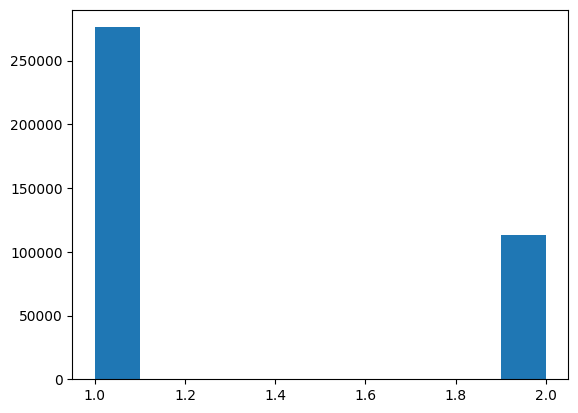

In [25]:
plt.hist(trans.account_id)

In [26]:
len(trans.service_object_id.unique())

6805

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [176]:
cols = ['id', 'task_id', 'task_stage_id', 'transitioned_by', 'transitioned_at', 'created_at', 'account_id', 
        'taskable_type', 'customer_id', 'object_type_id', 'deadline_at', 'created_at_incident', 'incident_type_id']
categorical = ['taskable_type']

In [88]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [200]:
def collect_data(df, categorical, num_days = 250):
    services = trans.service_object_id.unique()
    encoder = OrdinalEncoder()
    for col in categorical:
        encoded = encoder.fit_transform(df[[col]])

# Добавляем закодированные значения в DataFrame
        df[f'{col}_encoded'] = encoded
        
        # Удаление исходного категориального столбца (если требуется)
        # df.drop(col, axis=1, inplace=True)
    n_cols = len(df.columns) - 4
    mode = df.incident_type_id.mode()
    X = np.zeros((1, n_cols))
    y = Surv.from_arrays([True], [0], name_event='target').reshape(1, 1)
    for object in services:
        tasks = df[trans.service_object_id == object]
        tasks = tasks.sort_values(by='transitioned_at')
        task_ids = tasks.task_id.unique()
        num_collects = len(tasks[tasks.task_stage_id == 3])
        tasks['days2deadline'] = (tasks['deadline_at'] - tasks['transitioned_at']).dt.days
        tasks['daysSinceCreatetime'] = (tasks['transitioned_at'] - tasks['created_at']).dt.days
        if num_collects > 1:
            tasks_collects = tasks[tasks.task_stage_id == 3]
            tasks_collects['incident_type_id'] = tasks_collects['incident_type_id'].fillna(mode[0])
            tasks_collects['time'] = [min((tasks_collects['transitioned_at'].iloc[i] - tasks_collects['transitioned_at'].iloc[i-1]).days + 1, num_days)
                                     for i in range(1, num_collects)] + [min((end_point - tasks_collects['transitioned_at'].iloc[num_collects-1]).days + 1, num_days)]
            
            tasks_collects['target'] = [tasks_collects['time'].iloc[i] < num_days for i in range(num_collects)]
            tasks_collects = tasks_collects.drop(['transitioned_at', 'created_at', 'deadline_at', 'created_at_incident'] + categorical, axis = 1)
            
            X_batch = np.array(tasks_collects.drop(['time', 'target', 'id'], axis = 1))
            y_batch = Surv.from_dataframe('target', 'time', tasks_collects).reshape(num_collects, 1)

            X = np.vstack((X, X_batch))
            y = np.vstack((y, y_batch))
    return X[1:, :], y[1:, :], tasks
            # return tasks, 0
            
            

X, y, t = collect_data(trans[cols], categorical)
X

array([[ 1.0000e+00,  3.0000e+00,  1.3000e+01, ...,  1.0000e+00,
        -1.0000e+00, -1.8700e+02],
       [ 1.0000e+00,  3.0000e+00,  1.3000e+01, ...,  1.0000e+00,
        -4.0000e+00, -1.8500e+02],
       [ 2.0000e+00,  3.0000e+00,  1.3000e+01, ...,  1.0000e+00,
         0.0000e+00, -1.7800e+02],
       ...,
       [ 6.5863e+04,  3.0000e+00,  1.3900e+02, ...,  1.0000e+00,
        -4.0000e+00,  0.0000e+00],
       [ 6.5879e+04,  3.0000e+00,  1.7000e+02, ...,  1.0000e+00,
        -5.0000e+00,  0.0000e+00],
       [ 6.7225e+04,  3.0000e+00,  1.7000e+02, ...,  1.0000e+00,
        -2.0000e+00,  0.0000e+00]])

In [471]:
def predict_customer(df, X, y, estimator, customer_id, max_num = 50):
    idx = df[df.customer_id == customer_id].task_id.unique()
    task_ids = np.isin(X[:, 0], idx)
    if len(task_ids) > max_num:
        task_ids = np.where(task_ids)[0][-max_num:]
    data = X[task_ids]
    survival_function = estimator.predict_survival_function(data, return_array=True)
    cumulative_hazard_function = estimator.predict_cumulative_hazard_function(data, return_array=True)
    return survival_function, cumulative_hazard_function
    

survival_function, cumulative_hazard_function = predict_customer(trans, X, y, estimator, 1)

In [305]:
survival_function

array([[0.99984737, 0.89223969, 0.88505995, ..., 0.24427852, 0.24114498,
        0.24114498],
       [0.99989036, 0.92135767, 0.9160257 , ..., 0.36331676, 0.35996277,
        0.35996277],
       [0.99989983, 0.9279011 , 0.922994  , ..., 0.39653109, 0.39318542,
        0.39318542],
       ...,
       [0.99989623, 0.92540685, 0.92033738, ..., 0.38355447, 0.38020239,
        0.38020239],
       [0.99986891, 0.90671446, 0.90044446, ..., 0.29804289, 0.29475629,
        0.29475629],
       [0.99993302, 0.95119455, 0.947828  , ..., 0.53874099, 0.53569725,
        0.53569725]])

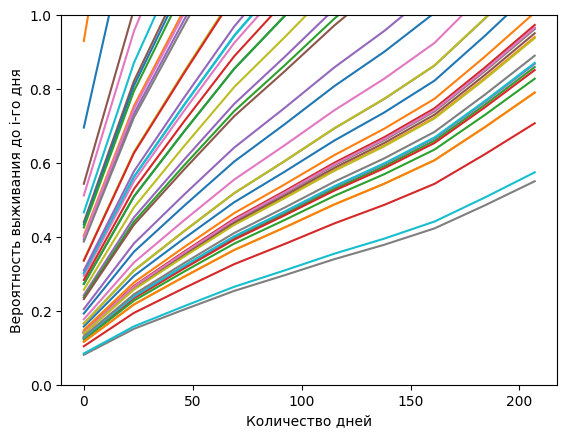

In [486]:
n_bins = 10
for obj in cumulative_hazard_function:
    dev = int(len(obj) / n_bins)
    obj_binned = np.mean(obj[:(len(obj)//dev)*dev].reshape(-1, dev), axis=1)
    plt.plot(np.arange(0, obj[:(len(obj)//dev)*dev].shape[0], dev), obj_binned)

plt.ylim(0, 1)
plt.xlabel("Количество дней")
plt.ylabel("Вероятность выживания до i-го дня")
plt.show()

In [474]:
obj_binned.tolist()

[0.08452374517490449,
 0.15784399374351482,
 0.21232564737836554,
 0.2648955330230625,
 0.30893095320691455,
 0.3545283853302656,
 0.3954685973396323,
 0.4415420808033366,
 0.5062466983955654,
 0.574649174142175]

In [477]:
np.arange(0, obj[:(len(obj)//dev)*dev].shape[0], dev).tolist()

[0, 23, 46, 69, 92, 115, 138, 161, 184, 207]

In [485]:
n_bins = 10
dev = int(cumulative_hazard_function.shape[1] / n_bins)
l = cumulative_hazard_function.shape[1]
n = cumulative_hazard_function.shape[0]
obj_binned = np.mean(cumulative_hazard_function[:, :(l//dev)*dev].reshape(n, -1, dev), axis=2)
obj_binned[:8].tolist()

[[0.19260751875609855,
  0.3596851976043061,
  0.48383464345083693,
  0.6036276698289815,
  0.7039728805321176,
  0.8078775080986659,
  0.9011695485324583,
  1.00615897265264,
  1.1536038808345075,
  1.309475241043004],
 [0.13836022814492227,
  0.2583810140034188,
  0.3475641661582606,
  0.4336178704315574,
  0.5057011740107776,
  0.5803413960969448,
  0.6473580322173149,
  0.7227775213830898,
  0.8286950435369562,
  0.9406657344995284],
 [0.1264057554686268,
  0.23605661620940757,
  0.31753424799965263,
  0.39615281957461634,
  0.4620080481166061,
  0.530199274653654,
  0.5914256012602306,
  0.6603287653622157,
  0.7570948995666271,
  0.8593912022775699],
 [0.10405171266248088,
  0.19431152569627239,
  0.26138036366197837,
  0.3260957477766135,
  0.3803049037772186,
  0.4364369515896781,
  0.48683579711556807,
  0.5435538809250902,
  0.6232075482313659,
  0.7074134094016272],
 [0.3928225144184465,
  0.7335769892811909,
  0.9867794488531222,
  1.2310970026826142,
  1.4357507889565042,


In [482]:
n_bins = 10
dev = int(len(obj) / n_bins)
obj_binned = np.mean(obj[:(len(obj)//dev)*dev].reshape(-1, dev), axis=1)
np.arange(0, obj[:(len(obj)//dev)*dev].shape[0], dev).tolist()

[0, 23, 46, 69, 92, 115, 138, 161, 184, 207]

In [494]:
def predict_task_id_any_customer(df, X, y, estimator, task_id, max_num = 10):
    x = X[X[:, 0] == task_id][0]
    lst = []
    survival_function = estimator.predict_survival_function([x], return_array=True)[0]
    lst.append((x[4], survival_function))
    for i in range(max_num):
        x[4] = np.random.randint(1, 395)
        survival_function = estimator.predict_survival_function([x], return_array=True)[0]
        lst.append((x[4], survival_function))
    return lst

    
    # task_ids = np.isin(X[:, 0], idx)
    # if len(task_ids) > max_num:
    #     task_ids = np.where(task_ids)[0][-max_num:]
    # data = X[task_ids]
    # survival_function = estimator.predict_survival_function(data, return_array=True)
    # cumulative_hazard_function = estimator.predict_cumulative_hazard_function(data, return_array=True)
    # return survival_function, cumulative_hazard_function
lst = predict_task_id_any_customer(trans, X, y, estimator, 500, max_num = 10)

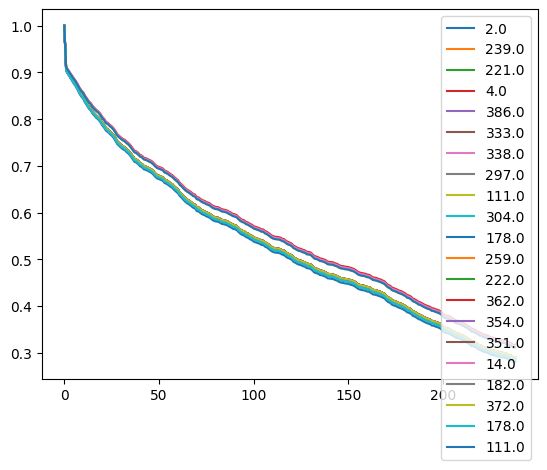

In [506]:
lst = predict_task_id_any_customer(trans, X, y, estimator, 500, max_num = 20)
for name, obj in lst:
    plt.plot(obj, label=name)
plt.legend()
plt.show()

In [448]:
trans[trans.task_id == 500]

,id,task_id,task_stage_id,transitioned_by,transitioned_at,created_at,updated_at,title,action_title,description,account_id,taskable_type,deadline_at,service_title,service_object_id,customer_id,object_type_id,incident_id,created_at_incident,incident_type_id
27561,1863,500,1,15,2021-12-08 14:45:22,2022-01-23 21:05:36,2022-01-23 21:05:36,Поставлена,Вернуть на доработку,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,511.0,2.0,1.0,NaN,NaT,NaN
27562,1863,500,1,15,2021-12-08 14:45:22,2022-01-23 21:05:36,2022-01-23 21:05:36,Поставлена,Вернуть на доработку,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,514.0,2.0,2.0,NaN,NaT,NaN
27563,1864,500,2,16,2021-12-08 15:20:12,2022-01-23 21:05:36,2022-01-23 21:05:36,Принята,Принять в работу,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,511.0,2.0,1.0,NaN,NaT,NaN
27564,1864,500,2,16,2021-12-08 15:20:12,2022-01-23 21:05:36,2022-01-23 21:05:36,Принята,Принять в работу,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,514.0,2.0,2.0,NaN,NaT,NaN
27565,1865,500,3,16,2021-12-08 15:21:59,2022-01-23 21:05:36,2022-01-23 21:05:36,Выполнена,Отметить выполненной,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,511.0,2.0,1.0,NaN,NaT,NaN
27566,1865,500,3,16,2021-12-08 15:21:59,2022-01-23 21:05:36,2022-01-23 21:05:36,Выполнена,Отметить выполненной,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,514.0,2.0,2.0,NaN,NaT,NaN
27567,1866,500,5,4,2021-12-10 09:16:28,2022-01-23 21:05:36,2022-01-23 21:05:36,Закрыта,Закрыть,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,511.0,2.0,1.0,NaN,NaT,NaN
27568,1866,500,5,4,2021-12-10 09:16:28,2022-01-23 21:05:36,2022-01-23 21:05:36,Закрыта,Закрыть,Заменить акб.,1.0,App\Models\ServiceDesk\Incident,2021-12-22 02:00:00,км 48+100 а/д г.Тимашевск - г.Приморско-Ахтарск,514.0,2.0,2.0,NaN,NaT,NaN


In [204]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [205]:
X_train

array([[ 2.9811e+04,  3.0000e+00,  1.3900e+02, ...,  1.0000e+00,
        -1.0000e+00,  0.0000e+00],
       [ 5.7520e+04,  3.0000e+00,  1.2800e+02, ...,  1.0000e+00,
         3.0000e+00,  0.0000e+00],
       [ 1.6000e+01,  3.0000e+00,  2.1000e+01, ...,  1.0000e+00,
        -1.0000e+00, -1.9200e+02],
       ...,
       [ 5.4897e+04,  3.0000e+00,  1.7000e+02, ...,  1.0000e+00,
        -1.0000e+00,  0.0000e+00],
       [ 6.1441e+04,  3.0000e+00,  1.3900e+02, ...,  1.0000e+00,
         0.0000e+00,  0.0000e+00],
       [ 3.7000e+01,  3.0000e+00,  2.0000e+01, ...,  1.0000e+00,
         0.0000e+00, -2.0100e+02]])

In [206]:
y_train.squeeze(-1)

array([( True, 116.), ( True, 129.), ( True,   1.), ..., ( True,  19.),
       ( True,   6.), ( True,   1.)],
      dtype=[('target', '?'), ('time', '<f8')])

In [183]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest

In [207]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest

estimator = GradientBoostingSurvivalAnalysis(
    n_estimators = 500,
    max_depth=7,
    max_features='sqrt',
    learning_rate = 0.01,
    # verbose=50, 
    # loss = 'squared'
).fit(X_train, y_train.squeeze(-1))

estimator.score(X_test, y_test.squeeze(-1))

0.8816443186754157

In [187]:
estimator = RandomSurvivalForest(
    n_estimators = 500,
    max_depth=7,
    max_features=None,
).fit(X_train, y_train.squeeze(-1))

estimator.score(X_test, y_test.squeeze(-1))

0.8033286812500482

In [247]:
estimator.get_params()

{'bootstrap': True,
 'low_memory': False,
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

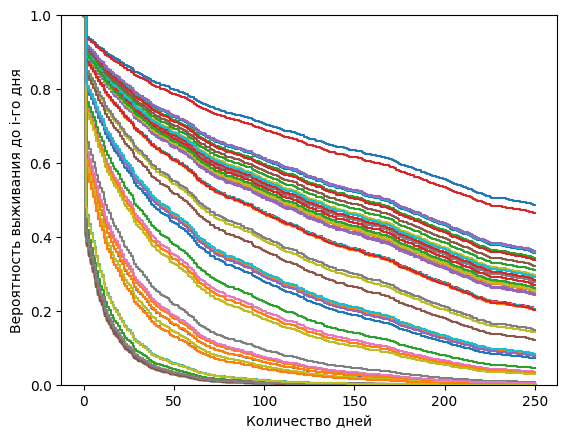

In [208]:
chf_funcs = estimator.predict_survival_function(X_test[:100, :])

for fn in chf_funcs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.xlabel("Количество дней")
plt.ylabel("Вероятность выживания до i-го дня")
plt.show()

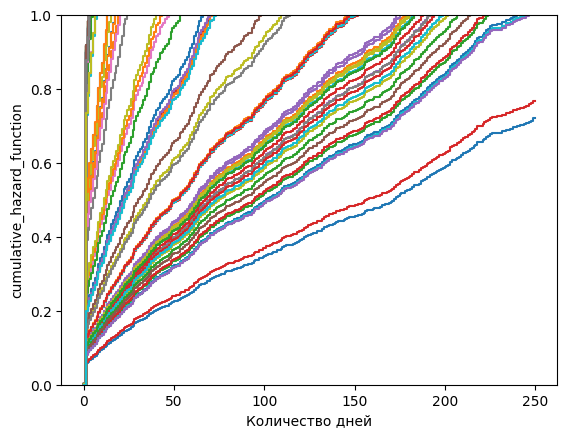

In [209]:
chf_funcs = estimator.predict_cumulative_hazard_function(X_test[:100, :])

for fn in chf_funcs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.xlabel("Количество дней")
plt.ylabel("cumulative_hazard_function")
plt.show()

In [210]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = estimator.predict(X_test)
y_true = [i[0][1] for i in y_test]
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(mae, mse)

56.18121240555095 11058.80727920677


(array([  3.,  39., 103., 129., 132.,  43.,  43.,  11.,  10.,  14.]),
 array([ 69.90447223, 102.73428309, 135.56409395, 168.39390481,
        201.22371567, 234.05352654, 266.8833374 , 299.71314826,
        332.54295912, 365.37276998, 398.20258084]),
 <BarContainer object of 10 artists>)

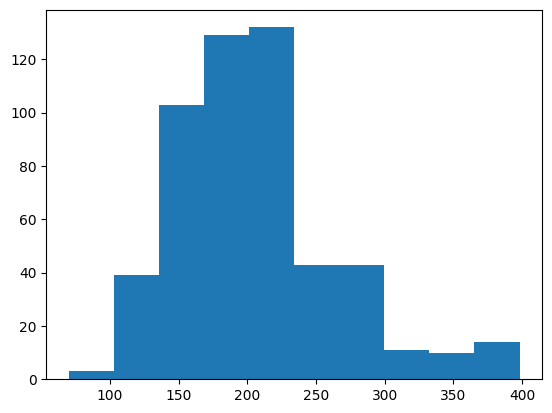

In [72]:
plt.hist(y_pred)

In [199]:
from sksurv.metrics import concordance_index_censored

IndexError: index 1 is out of bounds for axis 1 with size 1

In [96]:
d = trans[trans.service_object_id == 7]
len(d[d.task_stage_id == 3])

8

In [16]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389546 entries, 0 to 389545
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 389546 non-null  int64         
 1   task_id            389546 non-null  int64         
 2   task_stage_id      389546 non-null  int64         
 3   transitioned_by    389546 non-null  int64         
 4   transitioned_at    389546 non-null  datetime64[ns]
 5   created_at         389546 non-null  datetime64[ns]
 6   updated_at         389546 non-null  datetime64[ns]
 7   title              389546 non-null  object        
 8   action_title       389546 non-null  object        
 9   description        286350 non-null  object        
 10  service_title      232029 non-null  object        
 11  service_object_id  388193 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 35.7+ MB


In [20]:
!pip install scikit-survival lifelines -q

In [21]:
from sksurv.ensemble import RandomSurvivalForest
from lifelines.datasets import load_dd

In [42]:
from sksurv.datasets import load_whas500

X, y = load_whas500()
X = X.astype(float)
X

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1.0,83.0,0.0,25.54051,0.0,1.0,78.0,0.0,89.0,5.0,1.0,0.0,0.0,152.0
1,0.0,49.0,0.0,24.02398,0.0,1.0,60.0,0.0,84.0,5.0,0.0,1.0,0.0,120.0
2,0.0,70.0,0.0,22.14290,0.0,0.0,88.0,1.0,83.0,5.0,0.0,1.0,0.0,147.0
3,0.0,70.0,0.0,26.63187,1.0,1.0,76.0,0.0,65.0,10.0,0.0,1.0,0.0,123.0
4,0.0,70.0,0.0,24.41255,0.0,1.0,85.0,0.0,63.0,6.0,0.0,1.0,0.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,76.0,0.0,27.96454,0.0,1.0,88.0,1.0,68.0,1.0,0.0,1.0,0.0,112.0
496,0.0,76.0,0.0,24.26862,0.0,1.0,96.0,1.0,88.0,3.0,0.0,0.0,0.0,208.0
497,1.0,57.0,0.0,42.13576,0.0,1.0,74.0,1.0,123.0,3.0,0.0,0.0,0.0,120.0
498,0.0,67.0,0.0,27.40905,0.0,1.0,62.0,0.0,59.0,1.0,0.0,1.0,0.0,112.0


In [50]:
y[:5]

array([(False, 2178.), (False, 2172.), (False, 2190.), ( True,  297.),
       (False, 2131.)], dtype=[('fstat', '?'), ('lenfol', '<f8')])

In [44]:
estimator = RandomSurvivalForest().fit(X, y)

In [48]:
chf_funcs = estimator.predict_survival_function(X.iloc[:5])

for fn in chf_funcs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

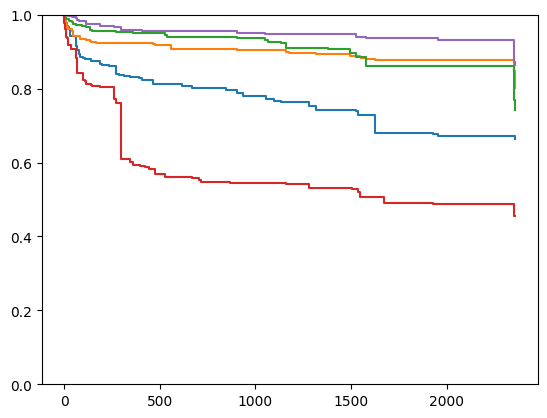

In [49]:
for fn in chf_funcs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()